** Structuring notebook **

In this notebook we will perform a few experiments with parsing a HTML document as given by a DO, and try to extract structures from it in such a way as to keep as much of its original intention as possible.

Once we can easily extract the structure, we will try to generate a series of nested documents derived from the original HTML, which we then intend on running through a clustering algorithm to get some classification going.

In [126]:
# We will parse HTML with BeautifulSoup
from bs4 import BeautifulSoup

During clustering we will ignore spaces. We will assume that all formatting information is contained in the tags themselves, either directly (in-line) or via the application of styles associated with classes.

In [127]:
# Get one of the extracted HTMLs, and trim the extra spaces and line breakes.
htmlfile = open("../newhtml/12906.html", encoding='utf8')
htmltext = ' '.join(htmlfile.read().replace('\n', '').replace('\r', '').split())
soup = BeautifulSoup(htmltext, 'html5lib')

In [130]:
# This gets all tags used in the documents, in a recursive manner.
list_of_tags = soup.find_all(True)

In [131]:
len(list_of_tags)

86

There's a lot of redundancy here, but that's OK. The objective is to get different classes of formats, which the algorithm will find by itself. This will then allow us to trim what is important and what is not.

In [141]:
tokenised = []
for tag in list_of_tags:
    tokenised.append(str(tag))
for token in tokenised:
    print(tokenised.index(token), '\n', token, '\n')

0 
 <html><head> <style> .topo_materia{ font-family: Verdana; font-size: 8pt; color: #000000; } .d_rtf{ font-family: Verdana; font-size: 12px; font-size-adjust: 0.4; color: #000000; font-weight: bold; vertical-align:30%; } a{ color:#000000; text-decoration: none; } a:hover{ color:#666666; font-weight: normal; text-decoration: none; } BODY{ scrollbar-face-color: ##E9D896; scrollbar-shadow-color: #f0f0f0; scrollbar-highlight-color: #ffffff; scrollbar-sdlight-color: #ffffff; scrollbar-darkshadow-color: #ffffff; scrollbar-track-color: #ffffff; scrollbar-arrow-color: #8D875A } </style> <script> function Imprimir_materia(mat_id, edi_id) { window.open("../../imprimir.htm?id="+mat_id+"&edi_id="+edi_id,"impressao","width='90%', height='90%' resisable, scrollbars=yes" ); } function AlertaBloqueio(){ alert('Conteúdo do site bloqueado'); return false; } function RejeitaTecla(oEvent){ var oEvent = oEvent ? oEvent : window.event; var tecla = (oEvent.keyCode) ? oEvent.keyCode : oEvent.which; if(tecla

Let's now try to get a corpus of documents, to run the clustering.

In [ ]:
import glob
files = glob.glob("../newhtml/*.html")
docid = 0
for file in files:
    htmlfile = open(file, encoding='utf8')
    htmltext = ' '.join(htmlfile.read().replace('\n', '').replace('\r', '').split())
    soup = BeautifulSoup(htmltext, 'html5lib')
    list_of_tags = soup.find_all(True)
    for tag in list_of_tags:
        token = str(tag)
        output = open("../tokens/" + str(docid) + '-' + str(list_of_tags.index(tag)) + '.txt', 'w')
        for line in token:
            output.write(line)
        output.close()
    docid = docid + 1

** Clustering **

We'll now run a few clustering algorithms to see how it behaves with our data. First, K-Means.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy.sparse import csr_matrix

In [2]:
%matplotlib inline

In [4]:
import glob
documents = []
files = glob.glob("../tokens/*.txt")
for file in files:
    tokenfile = open(file)
    documents.append(tokenfile.read())

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
pattern = u'(?:<\w+)|(?:\w+>)'
vectorizer = TfidfVectorizer(min_df=1, analyzer = 'word', token_pattern = pattern)
tfidf = vectorizer.fit_transform(documents)

In [75]:
vectorizer.vocabulary_

{'<a': 0,
 '<b': 1,
 '<body': 2,
 '<br': 3,
 '<div': 4,
 '<font': 5,
 '<h1': 6,
 '<h2': 7,
 '<h4': 8,
 '<h5': 9,
 '<h6': 10,
 '<head': 11,
 '<hr': 12,
 '<html': 13,
 '<i': 14,
 '<img': 15,
 '<meta': 16,
 '<nobr': 17,
 '<p': 18,
 '<script': 19,
 '<span': 20,
 '<strong': 21,
 '<style': 22,
 '<sup': 23,
 '<table': 24,
 '<tbody': 25,
 '<td': 26,
 '<thead': 27,
 '<title': 28,
 '<tr': 29,
 '<u': 30,
 'a>': 31,
 'b>': 32,
 'body>': 33,
 'div>': 34,
 'font>': 35,
 'h1>': 36,
 'h2>': 37,
 'h4>': 38,
 'h5>': 39,
 'h6>': 40,
 'head>': 41,
 'html>': 42,
 'i>': 43,
 'nobr>': 44,
 'p>': 45,
 'script>': 46,
 'span>': 47,
 'strong>': 48,
 'style>': 49,
 'sup>': 50,
 'table>': 51,
 'tbody>': 52,
 'td>': 53,
 'thead>': 54,
 'title>': 55,
 'tr>': 56,
 'u>': 57}

In [76]:
n = tfidf.shape[0]
m = tfidf.shape[1]
print('One dimension:', n)
print('Two dimension:', m)

One dimension: 63616
Two dimension: 58


In [77]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

In [78]:
from sklearn.metrics import pairwise_distances

def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    
    # Compute cluster assignments for each data point:
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment

In [79]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i.
        member_data_points = data[cluster_assignment==i,:]
        # Compute the mean of the data points.
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [80]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [81]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [82]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [89]:
k = 10
heterogeneity = []
initial_centroids = get_initial_centroids(tfidf, k, seed=0)
centroids, cluster_assignment = kmeans(tfidf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)

0


ZeroDivisionError: float division by zero

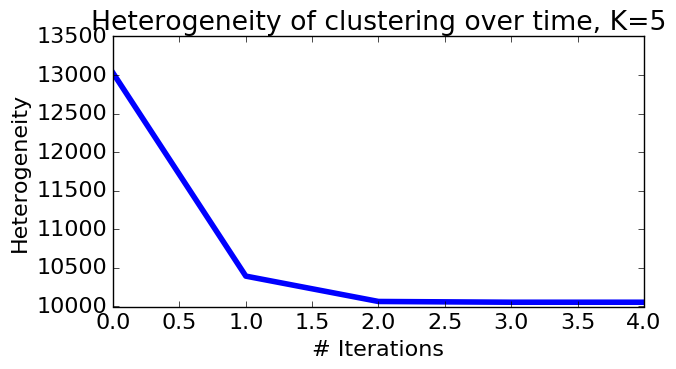

In [85]:
plot_heterogeneity(heterogeneity, k)

In [86]:
centroids

array([[  1.43398681e-04,   1.78524063e-03,   2.39132821e-05,
          0.00000000e+00,   8.28378077e-04,   9.74737775e-05,
          2.31588617e-04,   4.13496378e-05,   2.07934688e-04,
          7.55589446e-05,   1.57862731e-05,   1.19478846e-05,
          6.88444673e-05,   1.31862944e-05,   1.18377593e-04,
          1.45546961e-04,   7.52947305e-04,   0.00000000e+00,
          5.90607170e-01,   1.12214626e-05,   3.86672802e-01,
          5.37943755e-05,   6.24571519e-04,   1.23897868e-04,
          2.56263107e-04,   2.43890717e-04,   6.85951322e-04,
          0.00000000e+00,   3.16365453e-04,   7.19785655e-04,
          4.04813454e-05,   1.43398681e-04,   1.78524063e-03,
          2.39132821e-05,   8.28378077e-04,   9.74737775e-05,
          2.31588617e-04,   4.13496378e-05,   2.07934688e-04,
          7.55589446e-05,   1.57862731e-05,   1.19478846e-05,
          1.31862944e-05,   1.18377593e-04,   0.00000000e+00,
          5.90607170e-01,   1.12214626e-05,   3.86672802e-01,
        

In [87]:
cluster_assignment

array([3, 4, 4, ..., 2, 2, 4], dtype=int64)

In [88]:
for i in range(50):
    print(i, cluster_assignment[i], documents[i][:120])

0 3 <html><head> <style> .topo_materia{ font-family: Verdana; font-size: 8pt; color: #000000; } .d_rtf{ font-family: Verdana
1 4 <head> <style> .topo_materia{ font-family: Verdana; font-size: 8pt; color: #000000; } .d_rtf{ font-family: Verdana; font
2 4 <table align="center" width="50%"> <tbody> <tr> <td align="center" colspan="3" style="padding-left:15px;padding-top:10px
3 1 <span style='font-size:7.0pt;font-family:"Arial","sans-serif";color:black'> 40/000278/2013 </span>
4 4 <span style='font-size:7.0pt;font-family:"Arial","sans-serif";color:black'> - Convênio nº 95/2011 - Celebrado em 10/05/2
5 4 <p class="MsoNormal" style="text-align:justify;line-height:8.5pt"> <b> <span style='font-size:7.0pt;font-family:"Arial",
6 3 <b> <span style='font-size:7.0pt;font-family:"Arial","sans-serif";color:black'> 40/002549/2011 </span> </b>
7 1 <span style='font-size:7.0pt;font-family:"Arial","sans-serif";color:black'> 40/002549/2011 </span>
8 4 <span style='font-size:7.0pt;font-family:"Arial","san

In [25]:
documents[2]

'<table align="center" width="50%"> <tbody> <tr> <td align="center" colspan="3" style="padding-left:15px;padding-top:10px;"> <a href="../../" target="_top"> <img border="0" src="../../images/logo.jpg"/> </a> </td> <!--td style="padding-left:205px;" width="48%"> <b><font face="Verdana" size="2" color="#738197"></font></b> </td> <td align="right" style="padding-right:15px;"> <img src="images/logo_governo.gif" border="0"> </td!--> </tr> </tbody> </table>'